In [1]:

%reload_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt

from qick import *
from qick.helpers import gauss
from tqdm import tqdm_notebook as tqdm

import time
import os
import sys
sys.path.append('/home/xilinx/jupyter_notebooks/')
sys.path.append('C:\\_Lib\\python\\rfsoc\\rfsoc_multimode\\example_expts')
import scipy as sp
import json
from scipy.fft import fft, fftfreq

from slab.instruments import *
from slab.experiment import Experiment
from slab.datamanagement import SlabFile
from slab import get_next_filename, AttrDict
from slab import Experiment, dsfit, AttrDict

# Figure params
plt.rcParams['figure.figsize'] = [10,6]
plt.rcParams.update({'font.size': 14})

c:\Users\26049\.conda\envs\tomo\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Warning serial library import failed.
Could not load InstrumentManagerWindow
Could not import QickInstrument, try install qick package
Could not load AD5780 dac 
Could not load labbrick
Could not load Autonics TM4 Driver
Could not load Oxford Trition driver


In [2]:
from slab.dsfit import *
import os
from scipy.interpolate import griddata
from numpy import mgrid, array, zeros,abs,pi,cos,transpose, linspace
from matplotlib.ticker import MultipleLocator, FormatStrFormatter
from tempfile import TemporaryFile
font = {'family' : 'DejaVu Sans',
        'weight' : 'normal',
        'size'   : 15}
import json
from h5py import File
from datetime import datetime
import time
from slab.datamanagement import SlabFile
import matplotlib.pyplot as plt
import numpy as np
import os
import json
from slab.dsfit import *
from scipy.optimize import curve_fit
# import experiments.fitting as fitter
from matplotlib.colors import Normalize

In [3]:
import sys

# Path to add
expts_path = 'C:\\_Lib\\python\\multimode_expts'

# Add the path to the system path at the highest priority
if expts_path not in sys.path:
    sys.path.insert(0, expts_path)
    print('Path added at highest priority')

# Verify the path is added
print(sys.path)


Path added at highest priority
['C:\\_Lib\\python\\multimode_expts', 'h:\\Shared drives\\SLab\\Multimode\\experiment\\240911', 'C:\\_Lib\\python', 'C:\\_Lib\\python\\slab', 'C:\\_Lib\\python\\qick\\qick_lib', 'C:\\_Lib\\python\\rfsoc\\rfsoc_multimode\\example_expts', 'h:\\Shared drives\\SLab\\Multimode\\experiment\\240911', 'c:\\Users\\26049\\.conda\\envs\\tomo\\python38.zip', 'c:\\Users\\26049\\.conda\\envs\\tomo\\DLLs', 'c:\\Users\\26049\\.conda\\envs\\tomo\\lib', 'c:\\Users\\26049\\.conda\\envs\\tomo', '', 'C:\\Users\\26049\\AppData\\Roaming\\Python\\Python38\\site-packages', 'c:\\Users\\26049\\.conda\\envs\\tomo\\lib\\site-packages', 'c:\\Users\\26049\\.conda\\envs\\tomo\\lib\\site-packages\\win32', 'c:\\Users\\26049\\.conda\\envs\\tomo\\lib\\site-packages\\win32\\lib', 'c:\\Users\\26049\\.conda\\envs\\tomo\\lib\\site-packages\\Pythonwin', 'c:\\Users\\26049\\.conda\\envs\\tomo\\lib\\site-packages\\setuptools\\_vendor', '/home/xilinx/jupyter_notebooks/', 'C:\\_Lib\\python\\rfsoc\\rf

In [4]:
from multimode_expts.fit_display import *

importing from path  C:\_Lib\python\multimode_expts\experiments\clifford_averager_program.py
imported experiments.clifford_averager_program
importing from path  C:\_Lib\python\multimode_expts\experiments\fitting.py
imported experiments.fitting
importing from path  C:\_Lib\python\multimode_expts\experiments\qram_protocol_timestepped.py
imported experiments.qram_protocol_timestepped
importing from path  C:\_Lib\python\multimode_expts\experiments\qubit_cavity
imported experiments.qubit_cavity.amplitude_rabi_f0g1
imported experiments.qubit_cavity.displacement_enhanced_sideband
imported experiments.qubit_cavity.displace_amplitude_calibration
imported experiments.qubit_cavity.displace_pulse_probe
imported experiments.qubit_cavity.ecd
imported experiments.qubit_cavity.ecd_backup
imported experiments.qubit_cavity.ecd_read_spec
imported experiments.qubit_cavity.non_demolution_readout
imported experiments.qubit_cavity.out_and_back
imported experiments.qubit_cavity.photo_resolved_pulse_probe
impo

# Function used in experiment

In [5]:
def coherent_odd(alpha):
    return np.sinh(np.abs(alpha)**2)/np.exp(np.abs(alpha)**2)

def coherent_even(alpha):
    return np.cosh(np.abs(alpha)**2)/np.exp(np.abs(alpha)**2)
def Pn_poisson(x, c, n):
    alph = c * x # gain to |alpha| conversion
    Pn = alph**(2*n) * np.exp(-alph**2) / np.math.factorial(n)
    return Pn
def fitamp_new(p1, p2):
    fitamparray = []
    fitfreqarray = []
    
    fitamparray_err = []
    fitfreqarray_err = []

    n_peaks = int(len(p1))
    for i in range(n_peaks):
        fitamparray.append(p1[i][1])
        fitfreqarray.append(p1[i][2])
        fitamparray_err.append(np.sqrt(np.diag(p2[i])[1]))
        fitfreqarray_err.append(np.sqrt(np.diag(p2[i])[2]))
        
    return fitamparray , fitfreqarray, fitamparray_err, fitfreqarray_err
def fitamp(p1, p2):
    fitamparray = []
    fitfreqarray = []
    
    fitamparray_err = []
    fitfreqarray_err = []

    n_peaks = int((len(p1)-1)/3)
    for i in range(n_peaks):
        fitamparray.append(p1[3*i+1])
        fitfreqarray.append(p1[3*i+2])
        fitamparray_err.append(np.sqrt(np.diag(p2)[3*i+1]))
        fitfreqarray_err.append(np.sqrt(np.diag(p2)[3*i+2]))
        
    return fitamparray , fitfreqarray, fitamparray_err, fitfreqarray_err
def gaussfuncsum_with_baseline(x, *args):
    """p[0]+p[1]/(1+(x-p[2])**2/p[3]**2)"""
    y = 0 
    p = args
#     print(len(p))
    for ii in range(N):
        y = y + p[3*ii+1]*np.exp(-(x-p[3*ii+2])**2/(2*p[3*ii+3]**2))
    y += p[0]
    return y

def fitgausssum_with_baseline(xdata, ydata, fitparams=None):
    """fit lorentzian:
        returns [offset,amplitude,center,hwhm]"""
    fitdatax = xdata
    fitdatay = ydata        
    popt, pcov = curve_fit(gaussfuncsum_with_baseline, fitdatax, fitdatay, p0=fitparams, maxfev = 50000)

    return popt, pcov
def gauss_baseline(x, *p):
    return p[0] + p[1]*np.exp(-(x-p[2])**2/(2*p[3]**2))
def coherent_state(n, alpha):
    return np.exp(-abs(alpha)**2)*abs(alpha)**(2*n)/scipy.special.factorial(n)
def number_splitting(x, y, n=0, plot=False):
    """Fits an individual Gaussian around each number peak and returns an array
    of the peak values and frequency with error bars.
    'x': in units of χ so please pass it correctly, >0

    """
    # number of peaks
    num_peaks = int(max(x)+1)
    
    fitdata = {}
    peaks = []
    freqs = []
    peaks_err = []
    freqs_err = []
    if plot:
        fig, axs = plt.subplots(1, 1, dpi=300)
        plt.tight_layout()
        axs.set_xlabel(r'$n$', fontsize=20)
        axs.set_ylabel(r'$P_{e}$', fontsize=20)
        axs.grid(True, which='major', axis='both', color='grey', linestyle='--', linewidth=0.4)
        plt.tick_params(direction='in', length=6, width=2, colors='k', \
            grid_color='grey', grid_alpha=0.5, labelsize=20, labelbottom=True, right=True, top=True, left=True)
    
    for ind in range(num_peaks-n):
#         fitdata['n%.i'%ind] = {}
        """Fits the peak with a Gaussian spanning 1 unit of χ"""
        min_ind, max_ind =  np.argmin(abs(x-ind-0.5)), np.argmin(abs(x-ind+0.5))

        x_domain = x[min_ind:max_ind]
        y_domain = y[min_ind:max_ind]
        
        a = (y_domain[0] + y_domain[-1])/2
        b = (np.max(y_domain) - np.min(y_domain))
        c = x_domain[np.argmax(y_domain)]
        d = (np.max(x_domain) - np.min(x_domain))/4
        p = [a, b, c, d]
        popt, pcov = curve_fit(gauss_baseline, x_domain, y_domain, p0=(a, b, c, d))
        if plot:
            axs.plot(x_domain, y_domain, 'ks')
            axs.plot(x_domain, gauss_baseline(x_domain, *popt), 'r')
        
        freqs.append(popt[2])
        freqs_err.append(np.sqrt(np.diag(pcov)[2]))
        peaks.append(popt[1])
        peaks_err.append(np.sqrt(np.diag(pcov)[1]))
        
    fitdata['freq'] = freqs
    fitdata['peak'] = peaks
    fitdata['freq_err'] = freqs_err
    fitdata['peak_err'] = peaks_err
    if plot:
        plt.show()
    """Note: Don't forget to scale the returned frequency values with χ """
    return fitdata

def fitcoherentstate(peak_val, peak_val_err=0):
    xdata = np.arange(len(peak_val))
    ydata = np.array(peak_val)
    if peak_val_err:
        ydata_err = np.array(peak_val_err)
        popt, pcov = curve_fit(coherent_state, xdata, ydata, sigma=ydata_err)
    else:
        popt, pcov = curve_fit(coherent_state, xdata, ydata)

    return popt[0], np.sqrt(pcov[0][0])

# Experiment path

In [6]:
import json
import os
path = os.getcwd()
# print("path: ", path)

"""Reopen saved data"""
def prev_data(expt_path, filename):
    temp_data_file = expt_path+'/'+filename
    with SlabFile(temp_data_file) as a:
        attrs = dict()
        for key in list(a.attrs):
            attrs.update({key:json.loads(a.attrs[key])})
        keys = list(a)
        temp_data = dict()
        for key in keys:
            temp_data.update({key:np.array(a[key])})
        # print(f'Extracted data and attrs {list(a.attrs)}')
    return temp_data, attrs

expt_path=path+'\\data'
print('Data are extracted from', expt_path)

Data are extracted from h:\Shared drives\SLab\Multimode\experiment\240911\data


In [25]:
def DL_tomo_filter(expt_list, expt_path, thresholds):

    result = []   # a list, each element is a tuple of (s10, s01, s00, s11)

    for i in range(len(expt_list)):

        temp_data1, attrs1 = prev_data(expt_path, expt_list[i])  # I

        meas1, meas2 = filter_data_BS(temp_data1['I'][2::5], temp_data1['I'][3::5], temp_data1['I'][4::5], thresholds, post_selection = True)

        s00, s01, s10, s11 = 0, 0, 0, 0
        for j in range(len(meas1)):
            #  check if the counts are the same as initial counts
            if meas1[j]>thresholds: # classified as e
                if meas2[j]>thresholds:  # second e
                    s00 += 1
                else:
                    s01 +=1
            else:  # classified as g
                if meas2[j]>thresholds:  # second e
                    s10 +=1
                else:
                    s11 += 1

        result.append([s00, s01, s10, s11])
    return result

def histogram_tomography_DL_1q(expt_path, expt_name, demark_threshold, confusion_matrix=None, psi_id=basis(2,1).full()):
    
    result1 = DL_tomo_filter(expt_name, expt_path, demark_threshold)
    rescale_no = 10000

    N_tot1 = (result1[0][1]+result1[0][2])
    N_tot2 = (result1[1][1]+result1[1][2])
    N_tot3 = (result1[2][1]+result1[2][2])

    # rescale the counts

    N_Z0, N_X0, N_Y0 = np.round(result1[0][2]/N_tot1*rescale_no), np.round(result1[1][2]/N_tot2*rescale_no), np.round(result1[2][2]/N_tot3*rescale_no)
    N_Z1, N_X1, N_Y1 = np.round(result1[0][1]/N_tot1*rescale_no), np.round(result1[1][1]/N_tot2*rescale_no), np.round(result1[2][1]/N_tot3*rescale_no)

    N_tot1, N_tot2, N_tot3 = N_Z0+N_Z1, N_X0+N_X1, N_Y0+N_Y1



    if confusion_matrix is not None:
        N_Z0, N_Z1 = np.dot(confusion_matrix, np.array([N_Z0, N_Z1])).tolist()[0]
        N_X0, N_X1 = np.dot(confusion_matrix, np.array([N_X0, N_X1])).tolist()[0]
        N_Y0, N_Y1 = np.dot(confusion_matrix, np.array([N_Y0, N_Y1])).tolist()[0]

    
    n = np.array([N_Z0, N_Z1, N_X0, N_X1, N_Y0, N_Y1])
    print("PZ0 = %s, PX0 = %s, PY0 = %s" %(N_Z0/N_tot1,N_X0/N_tot2,N_Y0/N_tot3))
    print("Z0 = %d, X0 = %d, Y0 = %d" %(N_Z0,N_X0,N_Y0))
    print("Z1 = %d, X1 = %d, Y1 = %d" %(N_Z1,N_X1,N_Y1))

    #==== Compute state directly ====#
    rho_id = ket2dm(psi_id)

    # Provide n = expt. measurement counts for [Z0, Z1, X0, X1, Y0, Y1] here
    rho_linear = compute_rho_direct(n, eps=1e-10)
    rho_guess = (rho_id + rho_linear)/2


    #==== Perform MLE =====#
    def Likelihood(t_arr):
        T_mat = construct_T(t_arr)
        rho_expt = np.matmul(T_mat.conj().T,T_mat)
        rho_expt = rho_expt/np.trace(rho_expt)
        val = 0
        for state,n_val in zip(psi,n):
            state = state.full()
            proj = np.matmul(rho_expt,state)
            proj = np.matmul(state.conj().T,proj)[0][0]
            if proj !=0:
                val += abs((N_tot1*proj - n_val)**2 / (2*N_tot1*proj))

        return val

    optvals = optimize.minimize(Likelihood, t_from_rho(rho_guess.full()), \
                                method='L-BFGS-B')
    # methods = ‘Nelder-Mead’ ‘Powell’ ‘CG’ ‘BFGS’ ‘Newton-CG’ \
    # ‘L-BFGS-B’ ‘TNC’ ‘COBYLA’ ‘SLSQP’ ‘dogleg’ ‘trust-ncg’

    print("MLE convergence: ", optvals.success)
    rho_MLE = compute_rho_from_t_arr(optvals.x)
    print("Final fidleity (MLE squared): ", fidelity(rho_MLE, rho_id)**2)
    print("Purity:", np.trace(np.matmul(rho_MLE.full(),rho_MLE.full())))
    # print(rho_MLE)
    show_plot_rho(rho_MLE.full(), rho_id.full())
    return rho_MLE

# Maximum likelihood estimation

In [10]:
from qutip import *

In [11]:
#========= MLE related code ===========#
I2 = identity(2)
sx = sigmax()
sy = sigmay()
sz = sigmaz()

## 6 cardinal points on Bloch sphere
Z0 = basis(2,0)
Z1 = basis(2,1)
X0 = 1/np.sqrt(2)*(basis(2,0)+basis(2,1))
X1 = 1/np.sqrt(2)*(basis(2,0)-basis(2,1))
Y0 = 1/np.sqrt(2)*(basis(2,0)+1j*basis(2,1))
Y1 = 1/np.sqrt(2)*(basis(2,0)-1j*basis(2,1))

## Single-qubit measurements along different directions
psi = [Z0, Z1, X0, X1, Y0, Y1]

## Generate synthetic data for simulation
def generate_counts(rho_id, noise_fact=1.0):
    n = []
    for op in psi:
        n.append(N_tot*(op.dag()*rho_id*op).tr())

    for ii in range(int(len(n)/2)): # Better model for noise
        n[2*ii+0] = abs(random.gauss(n[2*ii+0], noise_fact*np.sqrt(n[2*ii+0])))
        n[2*ii+1] = N_tot - n[2*ii]
        if n[2*ii+1]<0: 
            print("Warning: Negative count obtained. Regenerate or try reducing noise.")
        
    n = np.round(n)
    return n

## Linear tomography, usually results in unphysical density matrix
def compute_rho_direct(n, eps=1e-10):
    # n is an array of measurement counts for [Z0, Z1, X0, X1, Y0, Y1]

    TZ = n[0] - n[1] 
    TX = n[2] - n[3] 
    TY = n[4] - n[5]
    TI = n[0] + n[1]

    rho_expt =  TI*I2 + TZ*sz + TX*sx + TY*sy

    rho_expt = rho_expt.full()/rho_expt.tr()
    rho_expt[np.abs(rho_expt) < eps] = 0 # Set small elements to 0
    return Qobj(rho_expt)

## Compute elements for the lower-triangular T-matrix
def t_from_rho(rho):
    t1=0; t2=0; t3=0; t4=0;
    
    t2 = np.sqrt(abs(rho[1][1]))
    if t2 != 0:
        t3 = np.real(rho[1][0]/t2)
        t4 = np.imag(rho[1][0]/t2)
    
    t1 = np.sqrt(rho[0][0]-t3**2-t4**2)
    
    return np.real(np.array([t1,t2,t3,t4]))


## Construction of the lower-triangular T-matrix
def construct_T(t):
    T_mat = []
    T_mat.append(np.array([t[0],          0,  ]))
    T_mat.append(np.array([t[2] +1j*t[3], t[1]]))
    return np.array(T_mat)

## Cholesky decomposition
def compute_rho_from_t_arr(t):
    T_mat=construct_T(t)
    rho = np.matmul(T_mat.conj().T,T_mat)
    rho = Qobj(rho/np.trace(rho))
    return rho
    

def Likelihood(t_arr):
    T_mat = construct_T(t_arr)
    rho_expt = np.matmul(T_mat.conj().T,T_mat)
    rho_expt = rho_expt/np.trace(rho_expt)
    val = 0
    for state,n_val in zip(psi,n):
        state = state.full()
        proj = np.matmul(rho_expt,state)
        proj = np.matmul(state.conj().T,proj)[0][0]
        if proj !=0:
            val += abs((N_tot*proj - n_val)**2 / (2*N_tot*proj))

    return val

## Function to plot density matrices
def show_plot_rho(rho_MLE, rho_id):
    labels = ["g", "e"]
    fig, ax = plt.subplots(nrows=2,ncols=2, figsize=(8,8))
    hinton(np.round(np.real(rho_MLE),decimals=10), xlabels=labels, ylabels=labels, ax=ax[0,0])
    hinton(np.round(np.imag(rho_MLE),decimals=10), xlabels=labels, ylabels=labels, ax=ax[0,1])
    ax[0,0].set_title("Re (rho_MLE)")
    ax[0,1].set_title("Imag (rho_MLE)")

    # fig1, ax1 = plt.subplots(nrows=1,ncols=2, figsize=(8,4))
    hinton(np.round(np.real(rho_id),decimals=10), xlabels=labels, ylabels=labels, ax=ax[1,0])
    hinton(np.round(np.imag(rho_id),decimals=10), xlabels=labels, ylabels=labels, ax=ax[1,1])
    ax[1,0].set_title("Re (rho_ideal)")
    ax[1,1].set_title("Imag (rho_ideal)")

# Two-qubit tomography

In [50]:
def DL_tomo_filter2(expt_list, expt_path, thresholds):

    result1 = []   # a list, each element is a tuple of (s10, s01, s00, s11)
    result2 = []

    for i in range(len(expt_list)):

        temp_data1, attrs1 = prev_data(expt_path, expt_list[i])  # I

        meas1, meas2 = filter_data_BS(temp_data1['I'][2::7], temp_data1['I'][3::7], temp_data1['I'][4::7], thresholds, post_selection = True)
        meas3, meas4 = filter_data_BS(temp_data1['I'][2::7], temp_data1['I'][5::7], temp_data1['I'][6::7], thresholds, post_selection = True)

        s00, s01, s10, s11 = 0, 0, 0, 0
        sp00, sp01, sp10, sp11 = 0, 0, 0, 0
        for j in range(len(meas1)):
            #  check if the counts are the same as initial counts
            if meas1[j]>thresholds: # classified as e
                if meas2[j]>thresholds:  # second e
                    s00 += 1
                    # for j in range(len(meas3)):
                    #  check if the counts are the same as initial counts
                    if meas3[j]>thresholds: # classified as e
                        if meas4[j]>thresholds:  # second e
                            sp00 += 1
                        else:
                            sp01 +=1
                    else:  # classified as g
                        if meas4[j]>thresholds:  # second e
                            sp10 +=1
                        else:
                            sp11 += 1

                else:  # second g
                    s01 +=1
                    # for j in range(len(meas3)):
                    #  check if the counts are the same as initial counts
                    if meas3[j]>thresholds: # classified as e
                        if meas4[j]>thresholds:  # second e
                            sp00 += 1
                        else:
                            sp01 +=1
                    else:  # classified as g
                        if meas4[j]>thresholds:  # second e
                            sp10 +=1
                        else:
                            sp11 += 1
            else:  # classified as g
                if meas2[j]>thresholds:  # second e
                    s10 +=1
                    # for j in range(len(meas3)):
                    #  check if the counts are the same as initial counts
                    if meas3[j]>thresholds: # classified as e
                        if meas4[j]>thresholds:  # second e
                            sp00 += 1
                        else:
                            sp01 +=1
                    else:  # classified as g
                        if meas4[j]>thresholds:  # second e
                            sp10 +=1
                        else:
                            sp11 += 1

                else:  # second g
                    s11 += 1
                    # for j in range(len(meas3)):
                    #  check if the counts are the same as initial counts
                    if meas3[j]>thresholds: # classified as e
                        if meas4[j]>thresholds:  # second e
                            sp00 += 1
                        else:
                            sp01 +=1
                    else:  # classified as g
                        if meas4[j]>thresholds:  # second e
                            sp10 +=1
                        else:
                            sp11 += 1

        result2.append([sp00, sp01, sp10, sp11])

        result1.append([s00, s01, s10, s11])

        
        
    return result1 ,result2

In [13]:

## Two-qubit correlation measurements along different directions
psi1 = []
psi1.append([tensor(Z0,Z0), tensor(Z0,Z1), tensor(Z1,Z0), tensor(Z1,Z1)]) # ZZ: 0 -- 3
psi1.append([tensor(Z0,X0), tensor(Z0,X1), tensor(Z1,X0), tensor(Z1,X1)]) # ZX: 4 -- 7
psi1.append([tensor(Z0,Y0), tensor(Z0,Y1), tensor(Z1,Y0), tensor(Z1,Y1)]) # ZY: 8 -- 11
psi1.append([tensor(X0,Z0), tensor(X0,Z1), tensor(X1,Z0), tensor(X1,Z1)]) # XZ: 12 -- 15
psi1.append([tensor(X0,X0), tensor(X0,X1), tensor(X1,X0), tensor(X1,X1)]) # XX: 16 -- 19
psi1.append([tensor(X0,Y0), tensor(X0,Y1), tensor(X1,Y0), tensor(X1,Y1)]) # XY: 20 -- 23
psi1.append([tensor(Y0,Z0), tensor(Y0,Z1), tensor(Y1,Z0), tensor(Y1,Z1)]) # YZ: 24 -- 27
psi1.append([tensor(Y0,X0), tensor(Y0,X1), tensor(Y1,X0), tensor(Y1,X1)]) # YX: 28 -- 31
psi1.append([tensor(Y0,Y0), tensor(Y0,Y1), tensor(Y1,Y0), tensor(Y1,Y1)]) # YY: 32 -- 35
psi1 = [y for x in psi1 for y in x] # Flatten the list

def compute_rho_direct1(n, eps=1e-10):
    # n is an array of 36 elements
    # ZZ, ZX, ZY, XZ, XX, XY, YZ, YX, YY each having 4 values: 00, 01, 10, 11
    TZZ = n[0] - n[1] - n[2] + n[3]
    TZX = n[4] - n[5] - n[6] + n[7]
    TZY = n[8] - n[9] - n[10] + n[11]
    TXZ = n[12] - n[13] - n[14] + n[15]
    TXX = n[16] - n[17] - n[18] + n[19]
    TXY = n[20] - n[21] - n[22] + n[23]
    TYZ = n[24] - n[25] - n[26] + n[27]
    TYX = n[28] - n[29] - n[30] + n[31]
    TYY = n[32] - n[33] - n[34] + n[35]

    TIZ = n[0] - n[1] + n[2] - n[3]
    TIX = n[4] - n[5] + n[6] - n[7]
    TIY = n[8] - n[9] + n[10] - n[11]

    TZI = n[0] + n[1] - n[2] - n[3]
    TXI = n[12] + n[13] - n[14] - n[15]
    TYI = n[24] + n[25] - n[26] - n[27]

    TII = n[0] + n[1] + n[2] + n[3]

    rho_expt =  TII*tensor(I2,I2)
    rho_expt += TZZ*tensor(sz,sz) + TZX*tensor(sz,sx) + TZY*tensor(sz,sy)
    rho_expt += TYZ*tensor(sy,sz) + TYX*tensor(sy,sx) + TYY*tensor(sy,sy)
    rho_expt += TXZ*tensor(sx,sz) + TXX*tensor(sx,sx) + TXY*tensor(sx,sy)
    rho_expt += TIZ*tensor(I2,sz) + TIX*tensor(I2,sx) + TIY*tensor(I2,sy)
    rho_expt += TZI*tensor(sz,I2) + TXI*tensor(sx,I2) + TYI*tensor(sy,I2)
    rho_expt = rho_expt.full()/rho_expt.tr()
    rho_expt[np.abs(rho_expt) < eps] = 0 # Set small elements to 0
    return Qobj(rho_expt,dims=[[2,2], [2,2]])

## Compute elements for the lower-triangular T-matrix
def t_from_rho1(rho):
    t1=0; t2=0; t3=0; t4=0; t5=0; t6=0; t7=0; t8=0;
    t9=0; t10=0; t11=0; t12=0; t13=0; t14=0; t15=0; t16=0
    
    t4 = np.sqrt(abs(rho[3][3]))
    if t4 != 0:
        t9  = np.real(rho[3][2]/t4)
        t10 = np.imag(rho[3][2]/t4)
        t13 = np.real(rho[3][1]/t4)
        t14 = np.imag(rho[3][1]/t4)
        t15 = np.real(rho[3][0]/t4)
        t16 = np.imag(rho[3][0]/t4)
    
    t3 = np.sqrt(rho[2][2]-t9**2-t10**2)
    if t3 != 0:
        t7  = np.real((rho[2][1] - (t9-t10*1j)*(t13+t14*1j)) /t3)
        t8  = np.imag((rho[2][1] - (t9-t10*1j)*(t13+t14*1j)) /t3)
        t11 = np.real((rho[2][0] - (t9-t10*1j)*(t15+t16*1j)) /t3)
        t12 = np.imag((rho[2][0] - (t9-t10*1j)*(t15+t16*1j)) /t3)
    
    t2 = np.sqrt(rho[1][1]-t7**2-t8**2-t13**2-t14**2)
    if t2 != 0:
        t5 = np.real((rho[1][0] - (t7-t8*1j)*(t11+t12*1j) - (t13-t14*1j)*(t15+t16*1j)) /t2)
        t6 = np.imag((rho[1][0] - (t7-t8*1j)*(t11+t12*1j) - (t13-t14*1j)*(t15+t16*1j)) /t2)
    
    t1 = np.sqrt(rho[0][0]-t5**2-t6**2-t11**2-t12**2-t15**2-t16**2)
    
    return np.real(np.array([t1,t2,t3,t4,t5,t6,t7,t8,t9,t10,t11,t12,t13,t14,t15,t16]))

## Construction of the lower-triangular T-matrix
def construct_T1(t):
    T_mat = []
    T_mat.append(np.array([t[0],           0,              0,               0]))
    T_mat.append(np.array([t[4] +1j*t[5],  t[1],           0,               0]))
    T_mat.append(np.array([t[10]+1j*t[11], t[6]+1j*t[7],   t[2],            0]))
    T_mat.append(np.array([t[14]+1j*t[15], t[12]+1j*t[13], t[8]+1j*t[9], t[3]]))
    return np.array(T_mat)

## Cholesky decomposition
def compute_rho_from_t_arr1(t):
    T_mat=construct_T1(t)
    rho = np.matmul(T_mat.conj().T,T_mat)
    rho = Qobj(rho/np.trace(rho),dims=[[2,2], [2,2]])
    return rho

def Likelihood1(t_arr, N_tot):
    T_mat = construct_T1(t_arr)
    rho_expt = np.matmul(T_mat.conj().T,T_mat)
    rho_expt = rho_expt/np.trace(rho_expt)
    val = 0
    for state,n_val in zip(psi1,n):
        state = state.full()
        proj = np.matmul(rho_expt,state)
        proj = np.matmul(state.conj().T,proj)[0][0]
        if proj !=0:
            val += abs((N_tot*proj - n_val)**2 / (2*N_tot*proj))

    return val

## Function to plot density matrices
def show_plot_rho1(rho_MLE, rho_id):
    labels = ["gg", "ge", "eg", "ee"]
    fig, ax = plt.subplots(nrows=2,ncols=2, figsize=(8,8))
    hinton(np.round(np.real(rho_MLE),decimals=10), xlabels=labels, ylabels=labels, ax=ax[0,0])
    hinton(np.round(np.imag(rho_MLE),decimals=10), xlabels=labels, ylabels=labels, ax=ax[0,1])
    ax[0,0].set_title("Re (rho_MLE)")
    ax[0,1].set_title("Imag (rho_MLE)")

    # fig1, ax1 = plt.subplots(nrows=1,ncols=2, figsize=(8,4))
    hinton(np.round(np.real(rho_id),decimals=10), xlabels=labels, ylabels=labels, ax=ax[1,0])
    hinton(np.round(np.imag(rho_id),decimals=10), xlabels=labels, ylabels=labels, ax=ax[1,1])
    ax[1,0].set_title("Re (rho_ideal)")
    ax[1,1].set_title("Imag (rho_ideal)")

def generate_counts(rho_id, N_tot=5000, noise_fact=1.0):
    ## 6 cardinal points on Bloch sphere
    Z0 = basis(2,0)
    Z1 = basis(2,1)
    X0 = 1/np.sqrt(2)*(basis(2,0)+basis(2,1))
    X1 = 1/np.sqrt(2)*(basis(2,0)-basis(2,1))
    Y0 = 1/np.sqrt(2)*(basis(2,0)+1j*basis(2,1))
    Y1 = 1/np.sqrt(2)*(basis(2,0)-1j*basis(2,1))

    ## Two-qubit correlation measurements along different directions
    psi = []
    psi.append([tensor(Z0,Z0), tensor(Z0,Z1), tensor(Z1,Z0), tensor(Z1,Z1)]) # ZZ: 0 -- 3
    psi.append([tensor(Z0,X0), tensor(Z0,X1), tensor(Z1,X0), tensor(Z1,X1)]) # ZX: 4 -- 7
    psi.append([tensor(Z0,Y0), tensor(Z0,Y1), tensor(Z1,Y0), tensor(Z1,Y1)]) # ZY: 8 -- 11
    psi.append([tensor(X0,Z0), tensor(X0,Z1), tensor(X1,Z0), tensor(X1,Z1)]) # XZ: 12 -- 15
    psi.append([tensor(X0,X0), tensor(X0,X1), tensor(X1,X0), tensor(X1,X1)]) # XX: 16 -- 19
    psi.append([tensor(X0,Y0), tensor(X0,Y1), tensor(X1,Y0), tensor(X1,Y1)]) # XY: 20 -- 23
    psi.append([tensor(Y0,Z0), tensor(Y0,Z1), tensor(Y1,Z0), tensor(Y1,Z1)]) # YZ: 24 -- 27
    psi.append([tensor(Y0,X0), tensor(Y0,X1), tensor(Y1,X0), tensor(Y1,X1)]) # YX: 28 -- 31
    psi.append([tensor(Y0,Y0), tensor(Y0,Y1), tensor(Y1,Y0), tensor(Y1,Y1)]) # YY: 32 -- 35
    psi = [y for x in psi for y in x] # Flatten the list
    
    n = []
    for op in psi:
        n.append(N_tot*(op.dag()*rho_id*op).tr())
        
    for ii in range(int(len(n)/4)): # Better model for noise
        n[4*ii+0] = abs(random.gauss(n[4*ii+0], noise_fact*np.sqrt(n[4*ii+0])))
        n[4*ii+1] = abs(random.gauss(n[4*ii+1], noise_fact*np.sqrt(n[4*ii+1])))
        n[4*ii+2] = abs(random.gauss(n[4*ii+2], noise_fact*np.sqrt(n[4*ii+2])))
        n[4*ii+3] = N_tot - (n[4*ii]+n[4*ii+1]+n[4*ii+2])
        if n[4*ii+3]<0: 
            print("Warning: Negative count obtained. Regenerate or try reducing noise.")
        
    n = np.round(n)
    return n

In [55]:
def histogram_tomography_2q(N_arr,psi_id=basis(2,1).full(),correct_meas = None):

    # N_arr: length=9 list of 4-element arrays, each array contains counts for [00, 01, 10, 11]
    # N_arr has to be scaled to total counts N_tot
    
    meas_list = ['ZZ', 'ZX', 'ZY', 'XZ', 'XX', 'XY', 'YZ', 'YX', 'YY']
    N_tot = np.sum(N_arr[0])

    if correct_meas is not None:

        # Compute corrected counts
        for ii in range(len(N_arr)):
            col_vec = []
            for elem in N_arr[ii]:
                col_vec.append([elem])
                
            f_vec = np.matmul(correct_meas,np.array(col_vec))
            N_arr[ii] = f_vec.flatten()
            
        # if fix_neg_counts: N_arr = fix_negative_counts(N_arr) # Fix negative counts
        print("Counts after:")
        for meas,elem in zip(meas_list,N_arr): print(meas, ':', np.around(elem))

    #==== Compute state directly ====#
    rho_id = ket2dm(psi_id)

    # Provide n = expt. measurement counts here
    n = np.concatenate(N_arr[0:9]).ravel()
    rho_linear = compute_rho_direct1(n, eps=1e-10)
    rho_guess = (rho_id + rho_linear)/2
    print("Direct overlap = ", np.trace(np.matmul(rho_linear.full(),rho_id.full())))
    # print(t_from_rho1(rho_linear.full()))


    #==== Perform MLE =====#
    def Likelihood1(t_arr):
        T_mat = construct_T1(t_arr)
        rho_expt = np.matmul(T_mat.conj().T,T_mat)
        rho_expt = rho_expt/np.trace(rho_expt)
        val = 0
        for state,n_val in zip(psi1,n):
            # print(state)
            state = state.full()
            proj = np.matmul(rho_expt,state)
            proj = np.matmul(state.conj().T,proj)[0][0]
            if proj !=0:
                val += abs((N_tot*proj - n_val)**2 / (2*N_tot*proj))

        return val
    optvals = optimize.fmin(Likelihood1, t_from_rho1(rho_linear.full()), \
                                xtol = 1E-10, ftol = 1E-10, maxiter = 23000, maxfun = 50000)
    # methods = ‘Nelder-Mead’ ‘Powell’ ‘CG’ ‘BFGS’ ‘Newton-CG’ \
    # ‘L-BFGS-B’ ‘TNC’ ‘COBYLA’ ‘SLSQP’ ‘dogleg’ ‘trust-ncg’

    rho_MLE = compute_rho_from_t_arr1(optvals)
    print("Final fidleity (MLE squared): ", fidelity(rho_MLE, rho_id)**2)
    print("Purity:", np.trace(np.matmul(rho_MLE.full(),rho_MLE.full())))
    print(rho_MLE)
    show_plot_rho1(rho_MLE.full(), rho_id.full())
    return rho_MLE

In [15]:
import json
import os
path = os.getcwd()
# print("path: ", path)

"""Reopen saved data"""
def prev_data(expt_path, filename):
    temp_data_file = expt_path+'/'+filename
    with SlabFile(temp_data_file) as a:
        attrs = dict()
        for key in list(a.attrs):
            attrs.update({key:json.loads(a.attrs[key])})
        keys = list(a)
        temp_data = dict()
        for key in keys:
            temp_data.update({key:np.array(a[key])})
        # print(f'Extracted data and attrs {list(a.attrs)}')
    return temp_data, attrs

expt_path=path+'\\data'
print('Data are extracted from', expt_path)

Data are extracted from h:\Shared drives\SLab\Multimode\experiment\240911\data


In [16]:
#========= Histogram and tomography related code ===========#

def custom_average(arr1d,avg_count):
    if avg_count>1:
        arr1d = np.mean(arr1d.reshape((avg_count, int(len(arr1d)/avg_count))), axis=0)
    return arr1d

def gaussian(x, amp, x0, sigma, offset):
    return amp * np.exp(-0.5*((x-x0)/sigma)**2) + offset

def find_guess_gaussian(xdata, ydata):
    x0 = xdata[np.argmax(ydata)]
    mean_cross = xdata[np.argmin(abs(ydata - np.mean(ydata)))]
    guess = np.array([0.75*max(ydata), xdata[np.argmax(ydata)], abs(x0-mean_cross), min(ydata)])
    return guess

def find_demark_index(ydata1, ydata2):
    err_arr=[]
    ind1 = np.argmax(ydata1)
    ind2 = np.argmax(ydata2)
    if ind1 < ind2:
        for ii in range(ind1,ind2):
            err_arr.append(sum(ydata2[0:ii])/sum(ydata2) + sum(ydata1[ii:])/sum(ydata1))
        d_index = np.argmin(err_arr) + ind1 # demarcation index
    else:
        for ii in range(ind2,ind1):
            err_arr.append(sum(ydata1[0:ii])/sum(ydata1) + sum(ydata2[ii:])/sum(ydata2))
        d_index = np.argmin(err_arr) + ind2 # demarcation index
#     return d_index, min(err_arr)/(sum(ydata1)+sum(ydata2))
    return d_index, min(err_arr)

def get_counts_below(arr, threshold):
    return sum(np.multiply(np.array(arr) < threshold, 1))


def histogram_tomography_1q(expt_path, expt_name, demark_threshold, confusion_matrix=None, psi_id=basis(2,1).full()):
    
    temp_data1, attrs1 = prev_data(expt_path, expt_name[0])  # I
    temp_data2, attrs2 = prev_data(expt_path, expt_name[1])  # X
    temp_data3, attrs3 = prev_data(expt_path, expt_name[2])  # Y

    N_tot1 = len(temp_data1['I'])
    N_tot2 = len(temp_data2['I'])
    N_tot3 = len(temp_data3['I'])

    N_Z0, N_X0, N_Y0 = 0, 0, 0
    N_Z1, N_X1, N_Y1 = 0, 0, 0

    for i in range(N_tot1):
        if temp_data1['I'][i] > demark_threshold:
            N_Z1 += 1
        else:
            N_Z0 += 1
    
    for i in range(N_tot2):
        if temp_data2['I'][i] > demark_threshold:
            N_X1 += 1
        else:
            N_X0 += 1

    for i in range(N_tot3):
        if temp_data3['I'][i] > demark_threshold:
            N_Y1 += 1
        else:
            N_Y0 += 1

    if confusion_matrix is not None:
        N_Z0, N_Z1 = np.dot(confusion_matrix, np.array([N_Z0, N_Z1])).tolist()[0]
        N_X0, N_X1 = np.dot(confusion_matrix, np.array([N_X0, N_X1])).tolist()[0]
        N_Y0, N_Y1 = np.dot(confusion_matrix, np.array([N_Y0, N_Y1])).tolist()[0]

    
    n = np.array([N_Z0, N_Z1, N_X0, N_X1, N_Y0, N_Y1])
    print("PZ0 = %s, PX0 = %s, PY0 = %s" %(N_Z0/N_tot1,N_X0/N_tot2,N_Y0/N_tot3))
    print("Z0 = %d, X0 = %d, Y0 = %d" %(N_Z0,N_X0,N_Y0))
    print("Z1 = %d, X1 = %d, Y1 = %d" %(N_Z1,N_X1,N_Y1))

    #==== Compute state directly ====#
    rho_id = ket2dm(psi_id)

    # Provide n = expt. measurement counts for [Z0, Z1, X0, X1, Y0, Y1] here
    rho_linear = compute_rho_direct(n, eps=1e-10)
    rho_guess = (rho_id + rho_linear)/2


    #==== Perform MLE =====#
    def Likelihood(t_arr):
        T_mat = construct_T(t_arr)
        rho_expt = np.matmul(T_mat.conj().T,T_mat)
        rho_expt = rho_expt/np.trace(rho_expt)
        val = 0
        for state,n_val in zip(psi,n):
            state = state.full()
            proj = np.matmul(rho_expt,state)
            proj = np.matmul(state.conj().T,proj)[0][0]
            if proj !=0:
                val += abs((N_tot1*proj - n_val)**2 / (2*N_tot1*proj))

        return val

    optvals = optimize.minimize(Likelihood, t_from_rho(rho_guess.full()), \
                                method='L-BFGS-B')
    # methods = ‘Nelder-Mead’ ‘Powell’ ‘CG’ ‘BFGS’ ‘Newton-CG’ \
    # ‘L-BFGS-B’ ‘TNC’ ‘COBYLA’ ‘SLSQP’ ‘dogleg’ ‘trust-ncg’

    print("MLE convergence: ", optvals.success)
    rho_MLE = compute_rho_from_t_arr(optvals.x)
    print("Final fidleity (MLE squared): ", fidelity(rho_MLE, rho_id)**2)
    print("Purity:", np.trace(np.matmul(rho_MLE.full(),rho_MLE.full())))
    print(rho_MLE)
    show_plot_rho(rho_MLE.full(), rho_id.full())
    return rho_MLE


# Experiment

## |g>

PZ0 = 1.0023295542786146, PX0 = 0.4451001708339804, PY0 = 0.4613552829114251
Z0 = 10023, X0 = 4451, Y0 = 4613
Z1 = -23, X1 = 5548, Y1 = 5386
MLE convergence:  True
Final fidleity (MLE squared):  0.9965238228543901
Purity: (0.9999999999999999+0j)
Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = True
Qobj data =
[[ 0.99652382+0.j         -0.04813648+0.03386698j]
 [-0.04813648-0.03386698j  0.00347618+0.j        ]]


Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = True
Qobj data =
[[ 0.99652382+0.j         -0.04813648+0.03386698j]
 [-0.04813648-0.03386698j  0.00347618+0.j        ]]

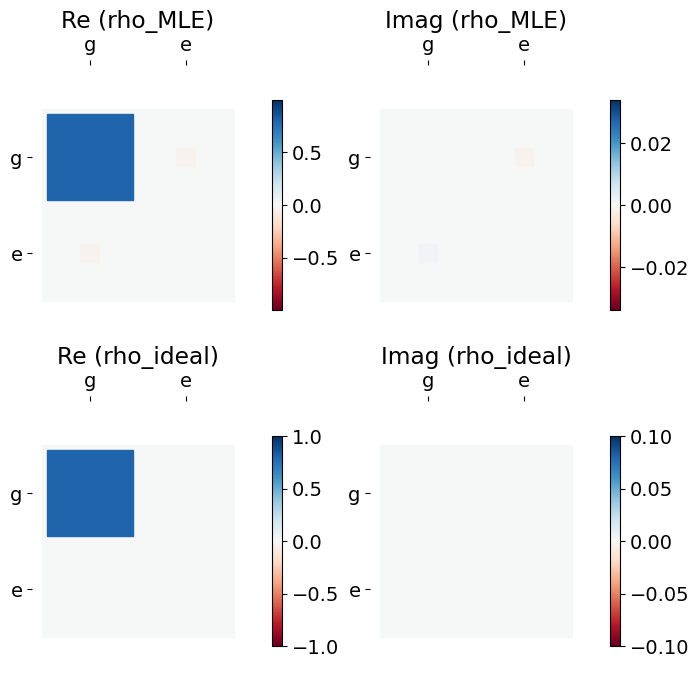

In [10]:
m = [0.98865, 0.011349999999999971, 0.0228, 0.9772]
confusion_matrix =  np.linalg.inv(np.matrix([[m[0], m[2]], [m[1], m[3]]]))

expt_name = ['00000_single_qubit_tomography.h5','00001_single_qubit_tomography.h5','00002_single_qubit_tomography.h5']
psi_id = (1*basis(2,0)+0*basis(2,1)).unit()
histogram_tomography_1q(expt_path, expt_name, -3.344664596874182, psi_id=psi_id, confusion_matrix=confusion_matrix)

## |e>

PZ0 = 0.002381322151472791, PX0 = 0.5288605891183931, PY0 = 0.5729668167934979
Z0 = 23, X0 = 5288, Y0 = 5729
Z1 = 9976, X1 = 4711, Y1 = 4270
MLE convergence:  True
Final fidleity (MLE squared):  0.9955508783023034
Purity: (1+0j)
Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = True
Qobj data =
[[0.00444912+0.j         0.02444403-0.06190167j]
 [0.02444403+0.06190167j 0.99555088+0.j        ]]


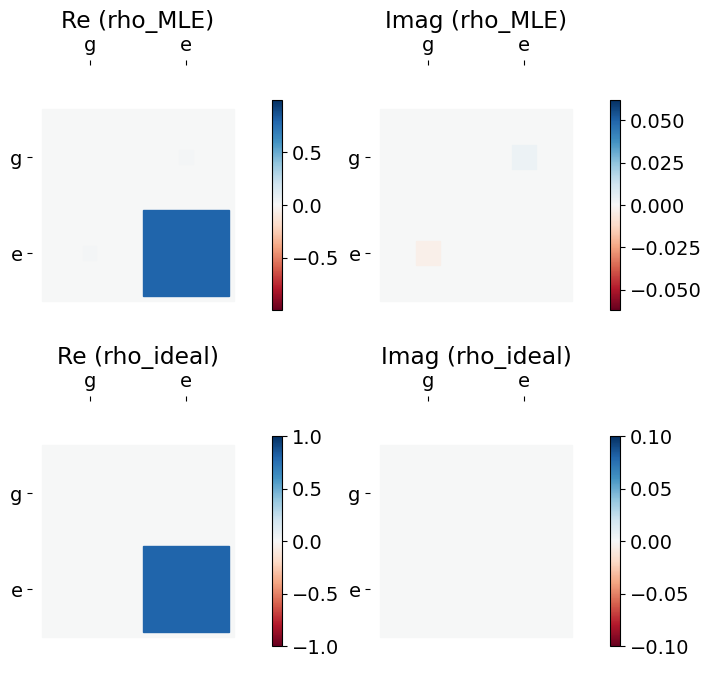

In [55]:
m = [0.98865, 0.011349999999999971, 0.0228, 0.9772]
confusion_matrix =  np.linalg.inv(np.matrix([[m[0], m[2]], [m[1], m[3]]]))

expt_name = ['00003_single_qubit_tomography.h5','00004_single_qubit_tomography.h5','00005_single_qubit_tomography.h5']
psi_id = (0*basis(2,0)+1*basis(2,1)).unit()
histogram_tomography_1q(expt_path, expt_name, -3.344664596874182, psi_id=psi_id, confusion_matrix=confusion_matrix)

## g+e

PZ0 = 0.440441062276751, PX0 = 0.9388621421545787, PY0 = 0.5265828027126365
Z0 = 2202, X0 = 4694, Y0 = 2632
Z1 = 2797, X1 = 305, Y1 = 2367
MLE convergence:  True
Final fidleity (MLE squared):  0.06113786011788202
Purity: (0.8937077816255425+0j)
Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = True
Qobj data =
[[0.44044106+0.j        0.43886214-0.0265828j]
 [0.43886214+0.0265828j 0.55955894+0.j       ]]


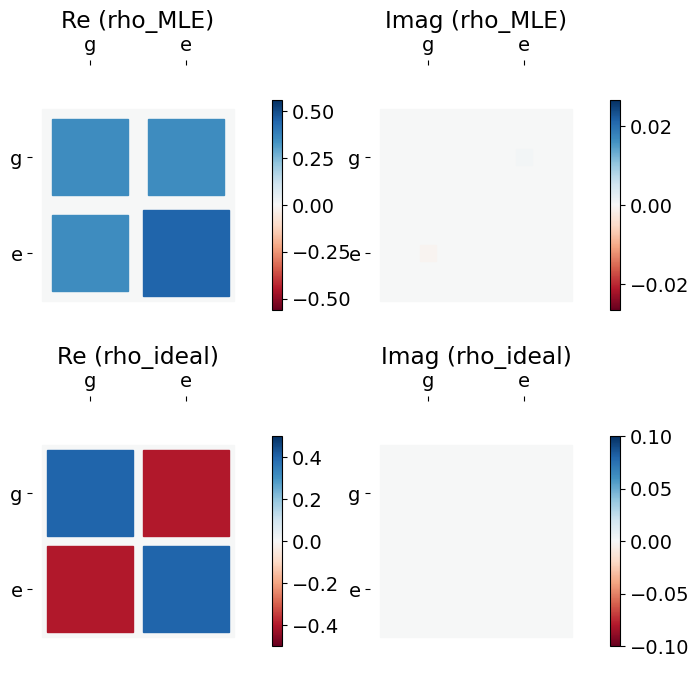

In [101]:
m = [0.98865, 0.011349999999999971, 0.0228, 0.9772]
confusion_matrix =  np.linalg.inv(np.matrix([[m[0], m[2]], [m[1], m[3]]]))

expt_name = ['00075_single_qubit_tomography.h5','00076_single_qubit_tomography.h5','00077_single_qubit_tomography.h5']
psi_id = (1*basis(2,0)-1*basis(2,1)).unit()
rr = histogram_tomography_1q(expt_path, expt_name, -5, psi_id=psi_id, confusion_matrix=confusion_matrix)

In [96]:
np.angle(rr.full()[0][1])/np.pi*180

-0.9054200342422138

## g+ie

PZ0 = 0.4461355282911425, PX0 = 0.46249417611430343, PY0 = 0.9991199461614122
Z0 = 4461, X0 = 4624, Y0 = 9991
Z1 = 5538, X1 = 5375, Y1 = 8
MLE convergence:  True
Final fidleity (MLE squared):  0.9971331766742368
Purity: (1.0000000000000002+0j)
Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = True
Qobj data =
[[ 0.4561146 +0.j         -0.03053992-0.49713317j]
 [-0.03053992+0.49713317j  0.5438854 +0.j        ]]


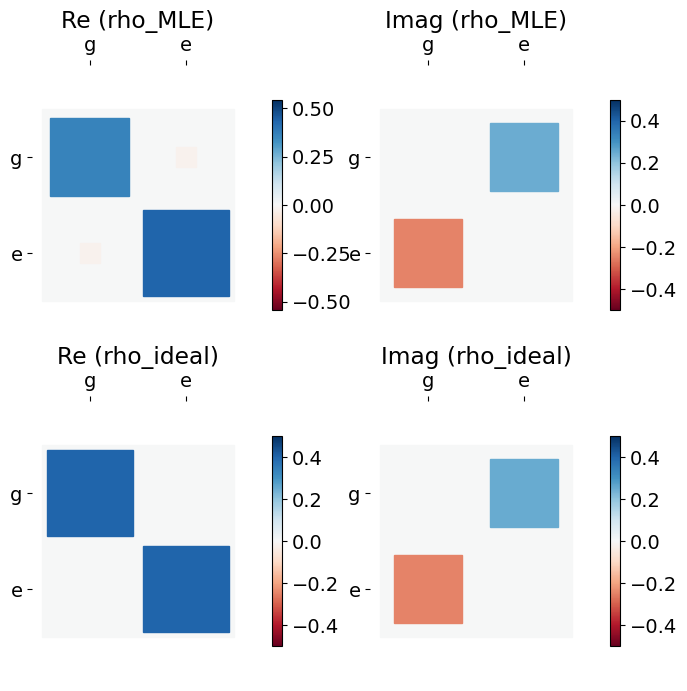

In [53]:
m = [0.98865, 0.011349999999999971, 0.0228, 0.9772]
confusion_matrix =  np.linalg.inv(np.matrix([[m[0], m[2]], [m[1], m[3]]]))

expt_name = ['00009_single_qubit_tomography.h5','00010_single_qubit_tomography.h5','00011_single_qubit_tomography.h5']
psi_id = (1*basis(2,0)+1j*basis(2,1)).unit()
histogram_tomography_1q(expt_path, expt_name, -3.344664596874182, psi_id=psi_id, confusion_matrix=confusion_matrix)

# Dual-rail tomography

## g

PZ0 = 0.9918, PX0 = 0.5014, PY0 = 0.5033
Z0 = 9918, X0 = 5014, Y0 = 5033
Z1 = 82, X1 = 4986, Y1 = 4967
MLE convergence:  True
Final fidleity (MLE squared):  0.9918000009405173
Purity: (0.9837601818435298+0j)


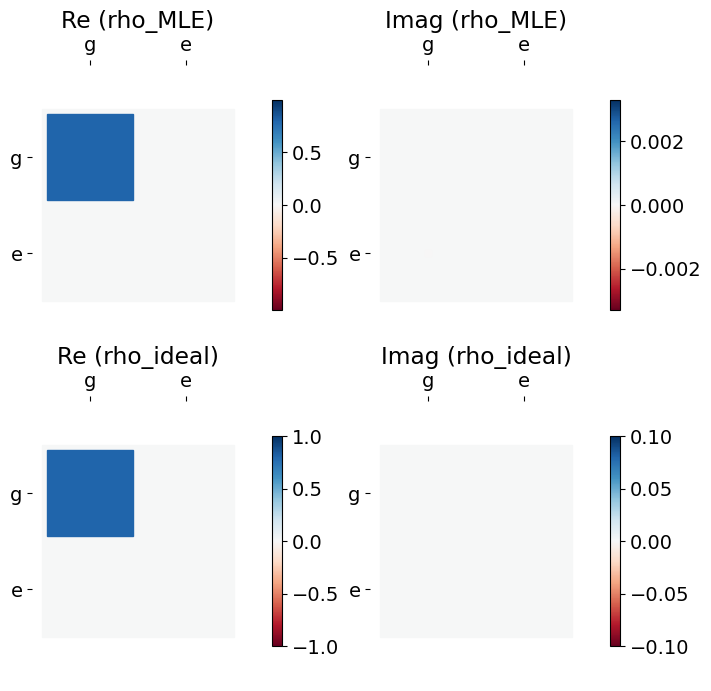

In [26]:
# m = [0.9355, 0.0645, 0.0110, 0.9890]
# confusion_matrix =  np.linalg.inv(np.matrix([[m[0], m[2]], [m[1], m[3]]]))
expt_name = ['00060_single_dual_rail_tomography.h5','00061_single_dual_rail_tomography.h5','00062_single_dual_rail_tomography.h5']
psi_id = (1*basis(2,0)+0j*basis(2,1)).unit()
rho_MLE = histogram_tomography_DL_1q(expt_path, expt_name, -68.123555375831074, psi_id=psi_id, confusion_matrix=None)

## e

PZ0 = 0.0126, PX0 = 0.517, PY0 = 0.503
Z0 = 126, X0 = 5170, Y0 = 5030
Z1 = 9874, X1 = 4830, Y1 = 4970
MLE convergence:  True
Final fidleity (MLE squared):  0.9874000010816765
Purity: (0.9757135217561221+0j)


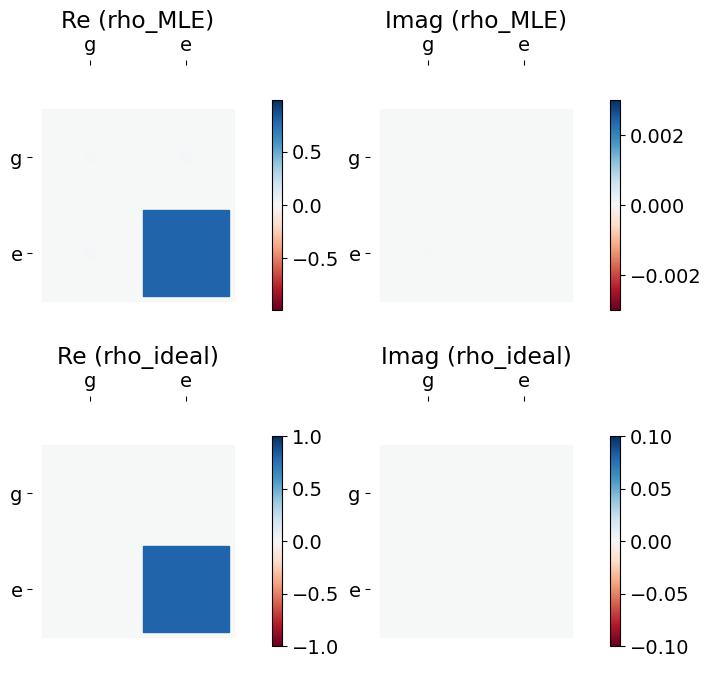

In [29]:
# m = [0.9355, 0.0645, 0.0110, 0.9890]
# confusion_matrix =  np.linalg.inv(np.matrix([[m[0], m[2]], [m[1], m[3]]]))
expt_name = ['00063_single_dual_rail_tomography.h5','00064_single_dual_rail_tomography.h5','00065_single_dual_rail_tomography.h5']
psi_id = (0*basis(2,0)+1*basis(2,1)).unit()
rho_MLE = histogram_tomography_DL_1q(expt_path, expt_name, -68.123555375831074, psi_id=psi_id, confusion_matrix=None)

## g+e

PZ0 = 0.4999, PX0 = 0.0378, PY0 = 0.6663
Z0 = 4999, X0 = 378, Y0 = 6663
Z1 = 5001, X1 = 9622, Y1 = 3337
MLE convergence:  True
Final fidleity (MLE squared):  0.9909678479884175
Purity: (0.9825690797451517+0j)


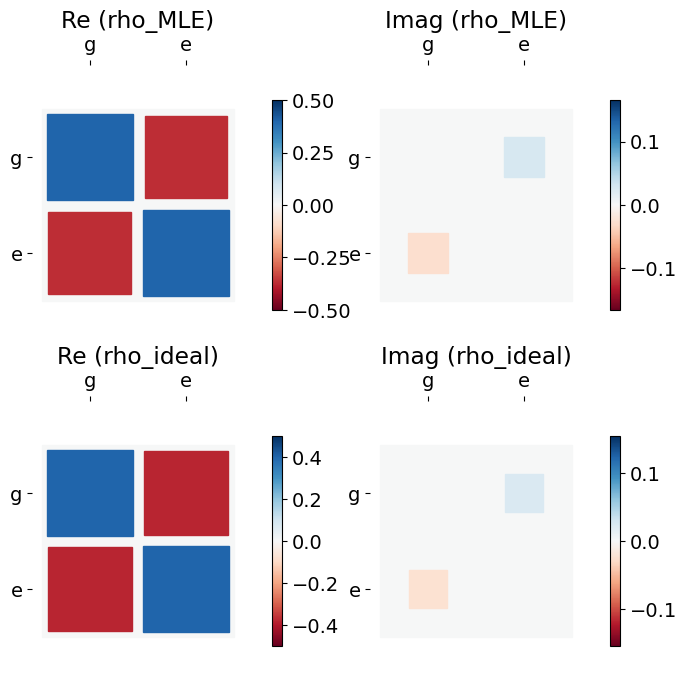

In [33]:
# m = [0.9355, 0.0645, 0.0110, 0.9890]
# confusion_matrix =  np.linalg.inv(np.matrix([[m[0], m[2]], [m[1], m[3]]]))
expt_name = ['00069_single_dual_rail_tomography.h5','00070_single_dual_rail_tomography.h5','00071_single_dual_rail_tomography.h5'] 
theta = -0.1*np.pi
psi_id = (basis(2,0)-np.exp(1j*theta)*basis(2,1)).unit()
rho_MLE = histogram_tomography_DL_1q(expt_path, expt_name, -68.123555375831074, psi_id=psi_id, confusion_matrix=None)

# Two Dual-rail qubit tomography

## gg

In [67]:
temp_data1, attrs1 = prev_data(expt_path, '00000_two_dual_rail_tomography.h5')

Direct overlap =  (0.9823958746973468+0j)
Optimization terminated successfully.
         Current function value: 17.636077
         Iterations: 7107
         Function evaluations: 9435
Final fidleity (MLE squared):  0.9793834028926189
Purity: (0.9626057024605441+0j)
Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = True
Qobj data =
[[ 9.79383403e-01+0.j          2.01132597e-02-0.02143124j
   1.82245793e-02-0.02008096j -1.43584424e-05-0.00068517j]
 [ 2.01132597e-02+0.02143124j  1.12329365e-02+0.j
   9.43553172e-04-0.00018569j  2.36611150e-04-0.00022431j]
 [ 1.82245793e-02+0.02008096j  9.43553172e-04+0.00018569j
   9.27926235e-03+0.j          1.30723541e-04-0.00020003j]
 [-1.43584424e-05+0.00068517j  2.36611150e-04+0.00022431j
   1.30723541e-04+0.00020003j  1.04398540e-04+0.j        ]]


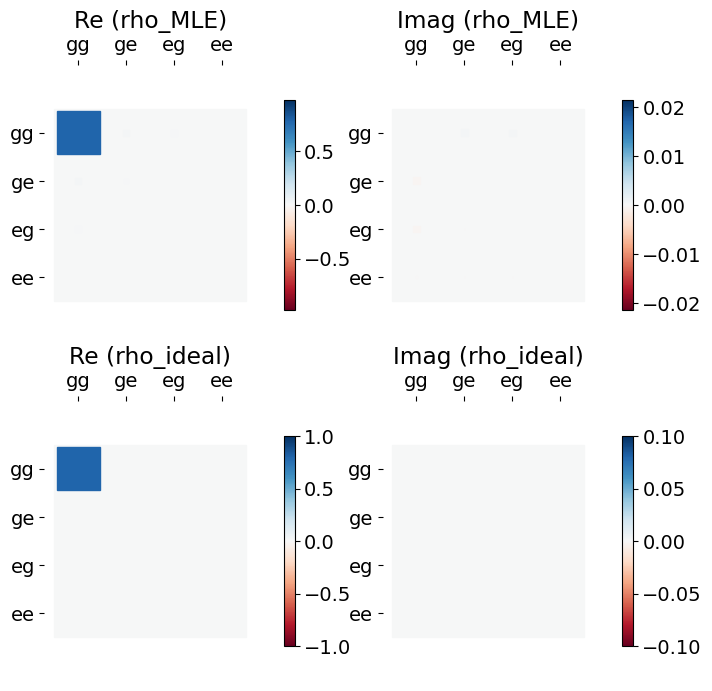

In [51]:
id_list = np.arange(9,18)
name_ = '_two_dual_rail_tomography.h5'
expt_list = []
for ii in id_list:
    expt_list.append('{:05d}'.format(ii)+name_)

thresholds = -51.123555375831074
r1, r2 = DL_tomo_filter2(expt_list, expt_path, thresholds)
N_arr = []
N_tot = 10000
for ii in range(len(r1)):
    ## 00, 01, 10, 11
    P00 = r1[ii][2]/(r1[ii][1]+r1[ii][2])*r2[ii][2]/(r2[ii][1]+r2[ii][2])
    P01 = r1[ii][2]/(r1[ii][1]+r1[ii][2])*r2[ii][1]/(r2[ii][1]+r2[ii][2])
    P10 = r1[ii][1]/(r1[ii][1]+r1[ii][2])*r2[ii][2]/(r2[ii][1]+r2[ii][2])
    P11 = r1[ii][1]/(r1[ii][1]+r1[ii][2])*r2[ii][1]/(r2[ii][1]+r2[ii][2])
    N_arr.append([P00*N_tot, P01*N_tot, P10*N_tot, P11*N_tot])

psi_id = tensor((1*basis(2,0)-0*basis(2,1)),(1*basis(2,0)-0*basis(2,1))).unit()
histogram_tomography_2q(N_arr,psi_id=psi_id,correct_meas = None)

## ge

In [48]:
id_list = np.arange(18,27)
name_ = '_two_dual_rail_tomography.h5'
expt_list = []
for ii in id_list:
    expt_list.append('{:05d}'.format(ii)+name_)

thresholds = -51.123555375831074
r1, r2 = DL_tomo_filter2(expt_list, expt_path, thresholds)
N_arr = []
N_tot = 10000
for ii in range(len(r1)):
    ## 00, 01, 10, 11
    P00 = r1[ii][2]/(r1[ii][1]+r1[ii][2])*r2[ii][2]/(r2[ii][1]+r2[ii][2])
    P01 = r1[ii][2]/(r1[ii][1]+r1[ii][2])*r2[ii][1]/(r2[ii][1]+r2[ii][2])
    P10 = r1[ii][1]/(r1[ii][1]+r1[ii][2])*r2[ii][2]/(r2[ii][1]+r2[ii][2])
    P11 = r1[ii][1]/(r1[ii][1]+r1[ii][2])*r2[ii][1]/(r2[ii][1]+r2[ii][2])
    N_arr.append([P00*N_tot, P01*N_tot, P10*N_tot, P11*N_tot])

Direct overlap =  (0.9849241108127365+0j)
Optimization terminated successfully.
         Current function value: 16.963905
         Iterations: 7713
         Function evaluations: 10294
Final fidleity (MLE squared):  0.9821201987717864
Purity: (0.9667036474685454+0j)
Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = True
Qobj data =
[[ 9.83680513e-03+0.00000000e+00j -1.34472020e-03+1.09327591e-02j
   2.06880949e-04-2.16854804e-04j  2.02572980e-05+1.16831305e-04j]
 [-1.34472020e-03-1.09327591e-02j  9.82120199e-01+0.00000000e+00j
  -2.39819521e-04-1.34564090e-05j  2.00713233e-02-2.16190177e-02j]
 [ 2.06880949e-04+2.16854804e-04j -2.39819521e-04+1.34564090e-05j
   8.67725585e-05+0.00000000e+00j -2.08159018e-05+9.99567949e-05j]
 [ 2.02572980e-05-1.16831305e-04j  2.00713233e-02+2.16190177e-02j
  -2.08159018e-05-9.99567949e-05j  7.95622354e-03+0.00000000e+00j]]


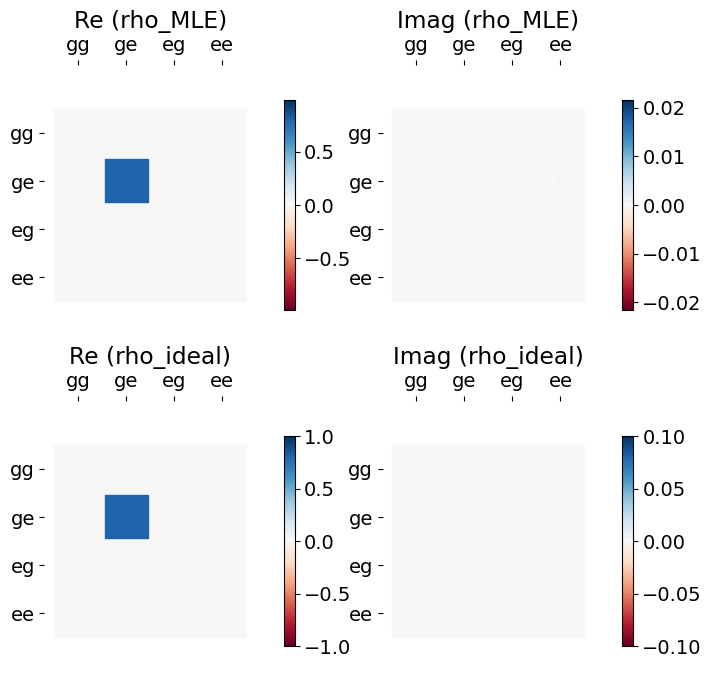

In [49]:
psi_id = tensor((1*basis(2,0)-0*basis(2,1)),(0*basis(2,0)-1*basis(2,1))).unit()
histogram_tomography_2q(N_arr,psi_id=psi_id,correct_meas = None)

## (g+e)(g+e)

Direct overlap =  (0.12999898450296954-1.3877787807814457e-17j)


C:\Users\26049\AppData\Local\Temp\ipykernel_12096\3673371841.py:50: RuntimeWarning: Maximum number of function evaluations has been exceeded.
  optvals = optimize.fmin(Likelihood1, t_from_rho1(rho_linear.full()), \


Final fidleity (MLE squared):  0.08446208839952721
Purity: (0.5529412630801259+0j)
Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = True
Qobj data =
[[ 0.24822999+0.j         -0.10122834+0.02202362j -0.08662504+0.19072341j
   0.01765191-0.10075445j]
 [-0.10122834-0.02202362j  0.24852442+0.j          0.07351925-0.07911556j
  -0.12834152+0.21214533j]
 [-0.08662504-0.19072341j  0.07351925+0.07911556j  0.253062  +0.j
  -0.10605207+0.04472255j]
 [ 0.01765191+0.10075445j -0.12834152-0.21214533j -0.10605207-0.04472255j
   0.25018359+0.j        ]]


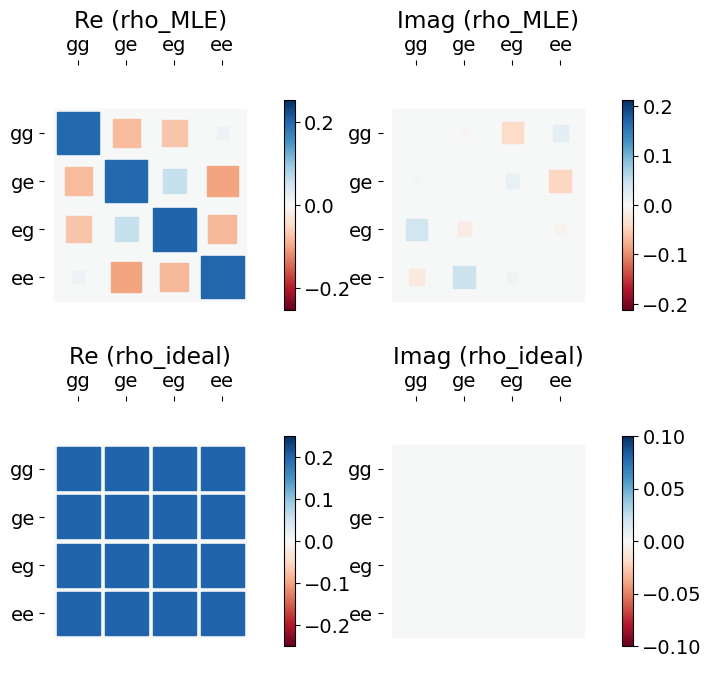

In [62]:
id_list = np.arange(27,36)
name_ = '_two_dual_rail_tomography.h5'
expt_list = []
for ii in id_list:
    expt_list.append('{:05d}'.format(ii)+name_)

thresholds = -68.123555375831074
r1, r2 = DL_tomo_filter2(expt_list, expt_path, thresholds)
N_arr = []
N_tot = 10000
for ii in range(len(r1)):
    ## 00, 01, 10, 11
    P00 = r1[ii][2]/(r1[ii][1]+r1[ii][2])*r2[ii][2]/(r2[ii][1]+r2[ii][2])
    P01 = r1[ii][2]/(r1[ii][1]+r1[ii][2])*r2[ii][1]/(r2[ii][1]+r2[ii][2])
    P10 = r1[ii][1]/(r1[ii][1]+r1[ii][2])*r2[ii][2]/(r2[ii][1]+r2[ii][2])
    P11 = r1[ii][1]/(r1[ii][1]+r1[ii][2])*r2[ii][1]/(r2[ii][1]+r2[ii][2])
    N_arr.append([P00*N_tot, P01*N_tot, P10*N_tot, P11*N_tot])

psi_id = tensor((1*basis(2,0)+1*basis(2,1)),(1*basis(2,0)+1*basis(2,1))).unit()
rr = histogram_tomography_2q(N_arr,psi_id=psi_id,correct_meas = None)

In [63]:
aa = Qobj(np.abs(rr.full()), dims = [[2, 2], [2, 2]], shape = (4, 4))

fidelity(aa, ket2dm(psi_id))**2

0.6932016164971582

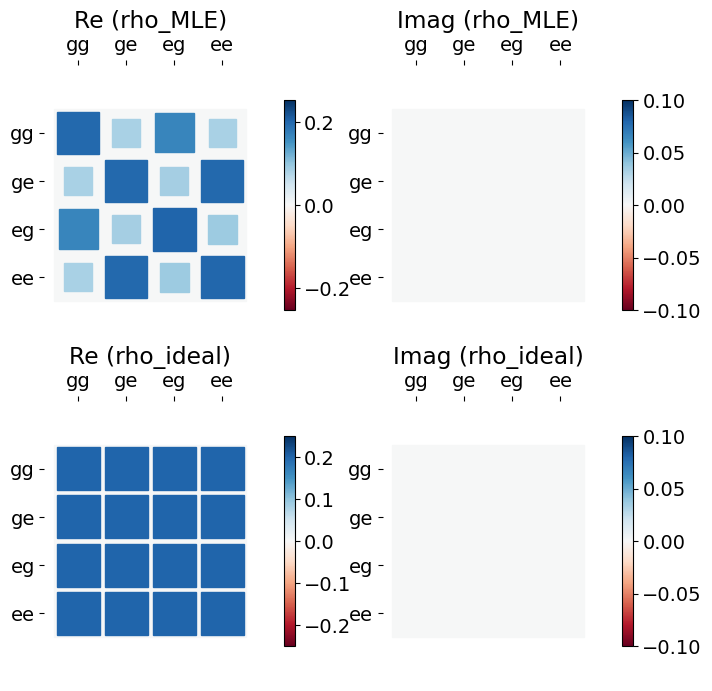

In [64]:
show_plot_rho1(aa.full(), ket2dm(psi_id).full())

In [ ]:
show_plot_rho1(rho_MLE.full(), rho_id.full())